<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 3 Jan P. Siegel - Deep Learning


##Allocate resources

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import os
import GPUtil as GPU
import psutil
import humanize

In [2]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

RAM Free: 12.7 GB  | Used: 118.4 MB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null
# > /dev/null omits command output

##Preprocessing


In [24]:
import gym
from gym import spaces
import cv2

# pasar a escala de grises y recortar imagen
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

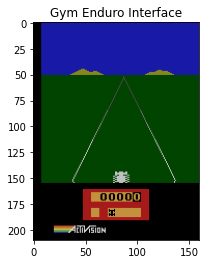

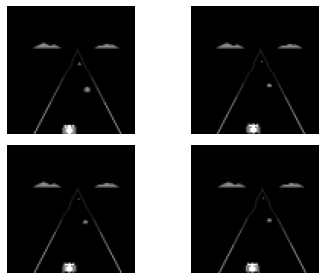

obs shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'] amount: 9


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4) # saltamos de a 4 frames para acelerar entrenamiento

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env) # pasamos el wrapper al enviroment
env = FrameStack(env,num_stack=4) # un estado definido como el actual mas los 3 anteriores
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print("obs shape:", obs.shape)
print("actions:", env.get_action_meanings(), "amount:", env.action_space.n)

### Actividad 1
Definimos un estado como un stack de el frame actual, más los 3 frames anteriores, por lo que cada estado (que será el input de la red) corresponde a 4 pasos de Enduro. Esto es clave para que la red convolucional pueda tener una noción de velocidad del jugador y de los demás competidores. La velocidad solo puede obtenerse comparando posiciones en frames contiguas, lo cual es información indispensable para que un agente pueda aprender a jugar Enduro competentemente.

### Fill replay memory

In [26]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list
        self.next_replace_position = 0

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        memory_data = (state, action, next_state, reward, done)
        if len(self) >= self.capacity:
          self.memory[self.next_replace_position] = memory_data
          self.next_replace_position += 1
          if self.next_replace_position > self.capacity - 1:
            self.next_replace_position = 0
        else:
          self.memory.append(memory_data)

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""
       sampled_tuples = random.sample(self.memory, batch_size) # list of tuples
       zipped = tuple(zip(*sampled_tuples))
       return zipped
      
    def __len__(self):
        return len(self.memory)

In [27]:
memory_size = 500000
replay_memory = ReplayMemory(memory_size)

print("Filling Replay Memory...")
current_obs = env.reset()
for _ in range(memory_size):
  if _ % 100000 == 0:
    print(f"{_}/{memory_size}")
  #print(_, replay_memory.next_replace_position, len(replay_memory))
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()
  else:
    current_obs = obs
print("Memory Filled!, Space taken:")
printm()

Filling Replay Memory...
0/500000
100000/500000
200000/500000
300000/500000
400000/500000
Memory Filled!, Space taken:
RAM Free: 10.7 GB  | Used: 7.7 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [23]:
a = tensor(4).item()
print(a)

4


##Model

In [28]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
      # X es un tensor (batch_size x 4 x 84 x 84) que representa un batch de stacks de estados
      batch_size = x.size(0)

      # forward pass red convolucional
      x = self.relu(self.conv1(x))
      x = self.relu(self.conv2(x))
      x = self.relu(self.conv3(x))
      x = torch.flatten(x, start_dim=1) # start_dim 1 para mantener separado el batch
      #print("State embedding:", x.shape, x)
      
      # forward pass rama fully-connected para V(s)
      v_s = self.relu(self.fc1_val(x))
      v_s = self.fc2_val(v_s).expand(batch_size, self.num_actions)
      #print("V(s):", v_s.shape, v_s)

      # forward pass rama fully-connected para A(s,a)
      adv = self.relu(self.fc1_adv(x))
      adv = self.fc2_adv(adv)
      #print("A(s,a):", adv.shape, adv)
      #print("mean A(s,a):", torch.mean(adv, 1, keepdim=True).shape, torch.mean(adv, 1, keepdim=True))

      # Calculo de Q(s,a) a partir de ecuacion (4)
      Q_values = v_s + (adv - torch.mean(adv, 1, keepdim=True)) # testeado

      return Q_values # batch_size x num_actions

##Training

In [29]:
def exploration(total_steps):
  """ retorna probabilidad de que explore con accion random """
  if total_steps >= 1000000:
    epsilon = 0.1
  else:
    m = -0.9 / 1000000
    n = 1
    epsilon = m * total_steps + n
  return epsilon

In [30]:
# Define parameters and instance NNs

from torch import device
import torch.optim as optim
import torch.nn as nn

device = device('cuda' if torch.cuda.is_available() else 'cpu')

frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
batch_size = 32
gamma = 0.99 # Factor de descuento
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se modifican los pesos (loss backprop) en la red Q
target_update_freq = 10000 # Frecuencia en que se actualizan los pesos de la red target Q' (cada x backprops, updateo Q')
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device) # esta es la que de verdad quiero entrenar
Q_target = Dueling_DQN(in_channels, num_actions).to(device) # para estabilidad, esta me entrega los labels

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = optim.Adam(Q.parameters(), lr=LR)

LOG_EVERY_N_STEPS = 50000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250000 # Pasos por época
N_EPOCHS = 10 # Número de épocas

In [31]:
from tqdm import tqdm
from torch import tensor, no_grad
import numpy as np

# Load checkpoint: probablemente se quede sin memoria durante entrenamiento,
# por eso hay que guardar checkpoint (pesos) en drive cada cierto tiempo
# luego cargamos checkpoint, rellenamos memory buffer, y retomamos
# pero el rellenado debe ser usando el modelo que tenemos hasta ahora! no random como el inicial

# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()
current_reward = 0
backprops = 0
episodes_rewards = []
epsilon_history = []
error_history = []

for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
    total_steps = t + STEPS_PER_EPOCH * epoch # steps acumulados a traves de las epocas
    ### 1. Choose actions and update replay memory buffer
    if t < learning_starts and epoch == 0:
      action = np.random.randint(num_actions)
    else:
      # epsilon greedy exploration
      sample = random.random()
      threshold = exploration(total_steps)  # la funcion exploration permite calcular el threshold para la política e-greedy
      epsilon_history.append(threshold)
      if sample <= threshold:
        action = np.random.randint(num_actions)
      else:
        with no_grad(): # no actualizamos gradientes pq estamos evaluando
          # Seleccionar la acción segun la red Q
          last_obs_tensor = torch.from_numpy(np.array(last_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
          last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
          all_q_values = Q(last_obs_tensor_batched)
          action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value

    obs, reward, done, _ = env.step(action) # ejecuto accion seleccionada
    replay_memory.push(last_obs, action, obs, reward, done) # actualizo experiencia en buffer
    current_reward += reward
    if done:
      # Termino episodio!
      obs = env.reset()
      # Guardar reward acumulado del episodio
      episodes_rewards.append(current_reward)
      current_reward = 0

    # update last_obs
    last_obs = obs

    ### 2. Perform experience replay and train the network.
    if (t > learning_starts and t % learning_freq == 0):
      obs_t, act_t, next_obs, rew_t, done_mask = replay_memory.sample(batch_size) # esto me deja listas de largo batch size
      # Pasar los arreglos a tensores y al device actual
      obs_t = torch.from_numpy(np.array(obs_t)).to(device)
      act_t = torch.from_numpy(np.array(act_t)).to(device)
      next_obs = torch.from_numpy(np.array(next_obs)).to(device)
      rew_t = torch.from_numpy(np.array(rew_t)).to(device)
      done_mask = torch.from_numpy(np.array(done_mask)).to(device)

      # Normalizar tensores de entrada
      obs_t = obs_t / 255.0
      next_obs = next_obs / 255.0

      # construir Y (labels)
      with no_grad(): # esto no debe ser parte del backprop, solo consigue los labels
        q_tp1_values = Q(next_obs)
        _, a_prime = q_tp1_values.max(1) # selecciono la mejor accion para el estado siguiente
        q_target_tp1_values = Q_target(next_obs)
        q_target_s_a_prime = q_target_tp1_values.gather(1, a_prime.unsqueeze(1)).squeeze() # selecciono el q_value de la target network segun la mejor accion en el estado siguiente
        # si termina en este episodio, los q_values de target son 0 y dejamos solo el reward
        q_target_s_a_prime = (1 - done_mask.type(torch.float)) * q_target_s_a_prime 
        
        y = rew_t + gamma * q_target_s_a_prime

      ## Loss calculation
      q_values = Q(obs_t)
      q_s_a = q_values.gather(1, act_t.unsqueeze(1)).squeeze() # selecciono el q de cada accion
      error = (y - q_s_a) ** 2
      error = torch.mean(error.clamp(-1, 1)) # clipeamos para estabilidad
      error_history.append(error)

      # backwards pass
      optimizer.zero_grad()
      error.backward()

      # update
      optimizer.step()
      backprops += 1

      # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)
      if backprops % target_update_freq == 0:
        print("Copying model wieghts...")
        Q_target.load_state_dict(Q.state_dict()) # copiamos pesos de Q a Qtarget
    
    if t % LOG_EVERY_N_STEPS == 0:
      print("\nEpoch:", epoch + 1)
      print("Current steps:", t, "Total Steps:", total_steps)
      try:
        print("Last 5 rewards:", episodes_rewards[-5:])
      except IndexError:
        print("Not enough rewards")
      try:
        print("Last 5 epsilons:", epsilon_history[-5:])
      except IndexError:
        print("Not enough epsilons")
      try:
        print("Last 5 errors:", error_history[-5:])
      except IndexError:
        print("Not enough errors")
      printm()
      # Mostrar resultados actuales
      # e.g. Mejor reward y promedio de ultimos 100 episodios
      # entre otros.
  model_save_path = my_dir + "/DQN_model{}.pt".format(epoch)
  torch.save(Q.state_dict(), model_save_path)    

    # Guardar modelo y resultados!
    # importante si se les cierra el entrenamiento

  0%|          | 182/250000 [00:00<04:36, 904.70it/s]


Epoch: 1
Current steps: 0 Total Steps: 0
Last 5 rewards: []
Last 5 epsilons: []
Last 5 errors: []
RAM Free: 10.7 GB  | Used: 7.7 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 20%|██        | 50031/250000 [00:54<04:19, 771.22it/s]


Epoch: 1
Current steps: 50000 Total Steps: 50000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.955]
Last 5 errors: []
RAM Free: 10.7 GB  | Used: 7.7 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 36%|███▌      | 90037/250000 [03:01<08:42, 306.19it/s]

Copying model wieghts...


 40%|████      | 100056/250000 [03:34<08:07, 307.76it/s]


Epoch: 1
Current steps: 100000 Total Steps: 100000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.9100036, 0.9100026999999999, 0.9100018, 0.9100009, 0.91]
Last 5 errors: [tensor(5.0542e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.2453e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(3.8949e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.6644e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(5.0048e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.6 GB  | Used: 8.0 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 52%|█████▏    | 130045/250000 [05:11<06:33, 305.14it/s]

Copying model wieghts...


 60%|██████    | 150047/250000 [06:16<05:32, 300.80it/s]


Epoch: 1
Current steps: 150000 Total Steps: 150000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.8650036, 0.8650027, 0.8650017999999999, 0.8650009, 0.865]
Last 5 errors: [tensor(2.2542e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(9.4088e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.4403e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.0095e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.3219e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.6 GB  | Used: 8.2 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 68%|██████▊   | 170049/250000 [07:23<04:26, 300.51it/s]

Copying model wieghts...


 80%|████████  | 200049/250000 [09:03<02:58, 279.81it/s]


Epoch: 1
Current steps: 200000 Total Steps: 200000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.8200035999999999, 0.8200027, 0.8200018, 0.8200008999999999, 0.82]
Last 5 errors: [tensor(3.1488e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.9118e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.5854e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.3721e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(8.2863e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.6 GB  | Used: 8.5 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 84%|████████▍ | 210049/250000 [09:37<02:15, 295.85it/s]

Copying model wieghts...


  0%|          | 140/250000 [00:00<06:16, 662.78it/s]


Epoch: 2
Current steps: 0 Total Steps: 250000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.7750036, 0.7750026999999999, 0.7750018, 0.7750009, 0.775]
Last 5 errors: [tensor(2.5575e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.0117e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(3.6808e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.4818e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.2223e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.6 GB  | Used: 8.8 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 20%|██        | 50001/250000 [01:12<05:14, 635.55it/s]


Epoch: 2
Current steps: 50000 Total Steps: 300000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.7300036, 0.7300027, 0.7300017999999999, 0.7300009000000001, 0.73]
Last 5 errors: [tensor(2.5575e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.0117e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(3.6808e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.4818e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.2223e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.6 GB  | Used: 8.8 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB
Copying model wieghts...


 36%|███▌      | 90056/250000 [03:32<09:31, 280.11it/s]

Copying model wieghts...


 40%|████      | 100049/250000 [04:07<08:47, 284.15it/s]


Epoch: 2
Current steps: 100000 Total Steps: 350000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.6850035999999999, 0.6850027, 0.6850018, 0.6850008999999999, 0.685]
Last 5 errors: [tensor(3.9240e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.9430e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(8.9903e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.0758e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(8.6700e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.5 GB  | Used: 9.0 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 52%|█████▏    | 130037/250000 [05:52<07:10, 278.63it/s]

Copying model wieghts...


 60%|██████    | 150041/250000 [07:03<06:08, 271.33it/s]


Epoch: 2
Current steps: 150000 Total Steps: 400000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.6400036, 0.6400026999999999, 0.6400018, 0.6400009, 0.6399999999999999]
Last 5 errors: [tensor(4.7482e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.3531e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(3.5979e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.8169e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(3.4467e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.5 GB  | Used: 9.3 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 68%|██████▊   | 170048/250000 [08:14<04:38, 286.63it/s]

Copying model wieghts...


 80%|████████  | 200047/250000 [10:03<03:13, 258.31it/s]


Epoch: 2
Current steps: 200000 Total Steps: 450000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.5950036, 0.5950027, 0.5950017999999999, 0.5950008999999999, 0.595]
Last 5 errors: [tensor(6.3654e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.3391e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.3489e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.5501e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.5212e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.5 GB  | Used: 9.6 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 84%|████████▍ | 210045/250000 [10:40<02:25, 273.86it/s]

Copying model wieghts...


  0%|          | 125/250000 [00:00<06:49, 609.54it/s]


Epoch: 3
Current steps: 0 Total Steps: 500000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.5500035999999999, 0.5500027, 0.5500018, 0.5500008999999999, 0.55]
Last 5 errors: [tensor(3.7195e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.7447e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(5.6007e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.7152e-11, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.5209e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.5 GB  | Used: 9.8 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 20%|██        | 50027/250000 [01:24<06:56, 480.49it/s]


Epoch: 3
Current steps: 50000 Total Steps: 550000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.5050036, 0.5050026999999999, 0.5050018, 0.5050009, 0.5049999999999999]
Last 5 errors: [tensor(3.7195e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.7447e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(5.6007e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.7152e-11, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.5209e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.5 GB  | Used: 9.9 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB
Copying model wieghts...


 36%|███▌      | 90053/250000 [03:52<09:58, 267.45it/s]

Copying model wieghts...


 40%|████      | 100033/250000 [04:29<09:17, 268.98it/s]


Epoch: 3
Current steps: 100000 Total Steps: 600000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.46000359999999996, 0.4600027, 0.4600018, 0.46000089999999993, 0.45999999999999996]
Last 5 errors: [tensor(3.4409e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(6.4525e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(6.4206e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.6292e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(8.0934e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.4 GB  | Used: 10.1 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 52%|█████▏    | 130061/250000 [06:21<07:26, 268.75it/s]

Copying model wieghts...


 60%|██████    | 150029/250000 [07:35<06:19, 263.50it/s]


Epoch: 3
Current steps: 150000 Total Steps: 650000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.4150035999999999, 0.41500269999999995, 0.4150018, 0.4150009, 0.4149999999999999]
Last 5 errors: [tensor(9.9929e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.7736e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(6.5489e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.0091e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(9.0631e-10, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.4 GB  | Used: 10.4 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 68%|██████▊   | 170051/250000 [08:51<04:54, 271.57it/s]

Copying model wieghts...


 80%|████████  | 200041/250000 [10:45<03:16, 254.18it/s]


Epoch: 3
Current steps: 200000 Total Steps: 700000
Last 5 rewards: [0.0, 2.0, 2.0, 9.0, 0.0]
Last 5 epsilons: [0.3700036, 0.3700026999999999, 0.37000179999999994, 0.37000089999999997, 0.37]
Last 5 errors: [tensor(5.6966e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(6.1078e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.3081e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.6540e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(2.7514e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.4 GB  | Used: 10.7 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 84%|████████▍ | 210057/250000 [11:23<02:31, 264.37it/s]

Copying model wieghts...


  0%|          | 116/250000 [00:00<07:19, 568.36it/s]


Epoch: 4
Current steps: 0 Total Steps: 750000
Last 5 rewards: [0.0, 0.0, 0.0, 1.0, 1.0]
Last 5 epsilons: [0.32500359999999995, 0.3250027, 0.3250017999999999, 0.3250008999999999, 0.32499999999999996]
Last 5 errors: [tensor(0.0313, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(5.5566e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(9.2691e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(5.4411e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.0467e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.4 GB  | Used: 10.9 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 20%|██        | 50016/250000 [01:37<07:15, 458.76it/s]


Epoch: 4
Current steps: 50000 Total Steps: 800000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.2800035999999999, 0.28000269999999994, 0.28000179999999997, 0.2800009, 0.2799999999999999]
Last 5 errors: [tensor(0.0313, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(5.5566e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(9.2691e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(5.4411e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.0467e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 10.4 GB  | Used: 10.9 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB
Copying model wieghts...


 36%|███▌      | 90049/250000 [04:13<10:32, 253.03it/s]

Copying model wieghts...


 40%|████      | 100027/250000 [04:52<10:14, 244.13it/s]


Epoch: 4
Current steps: 100000 Total Steps: 850000
Last 5 rewards: [0.0, 0.0, 0.0, 0.0, 0.0]
Last 5 epsilons: [0.23500359999999998, 0.2350026999999999, 0.23500179999999993, 0.23500089999999996, 0.235]
Last 5 errors: [tensor(4.5268e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.8606e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(4.1602e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.0483e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(7.4516e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 9.4 GB  | Used: 11.2 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 52%|█████▏    | 130041/250000 [06:50<07:55, 252.13it/s]

Copying model wieghts...


 60%|██████    | 150024/250000 [08:10<06:32, 254.97it/s]


Epoch: 4
Current steps: 150000 Total Steps: 900000
Last 5 rewards: [0.0, 1.0, 4.0, 30.0, 0.0]
Last 5 epsilons: [0.19000359999999994, 0.19000269999999997, 0.1900017999999999, 0.19000089999999992, 0.18999999999999995]
Last 5 errors: [tensor(0.0313, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(6.4222e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.5284e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.3863e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>), tensor(1.4462e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)]
RAM Free: 9.4 GB  | Used: 11.5 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 68%|██████▊   | 170055/250000 [09:30<05:17, 252.15it/s]

Copying model wieghts...


 80%|████████  | 200029/250000 [11:30<03:18, 251.13it/s]


Epoch: 4
Current steps: 200000 Total Steps: 950000
Last 5 rewards: [16.0, 0.0, 2.0, 16.0, 3.0]
Last 5 epsilons: [0.1450035999999999, 0.14500269999999993, 0.14500179999999996, 0.1450009, 0.1449999999999999]
Last 5 errors: [tensor(0.0002, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0001, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0298, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0002, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0298, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 9.4 GB  | Used: 11.7 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 84%|████████▍ | 210064/250000 [12:10<02:38, 252.27it/s]

Copying model wieghts...


  0%|          | 107/250000 [00:00<08:04, 516.18it/s]


Epoch: 5
Current steps: 0 Total Steps: 1000000
Last 5 rewards: [13.0, 23.0, 14.0, 7.0, 18.0]
Last 5 epsilons: [0.10000359999999997, 0.10000269999999989, 0.10000179999999992, 0.10000089999999995, 0.1]
Last 5 errors: [tensor(0.0001, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0626, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 8.5 GB  | Used: 12.0 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 20%|██        | 50003/250000 [01:48<07:36, 437.69it/s]


Epoch: 5
Current steps: 50000 Total Steps: 1050000
Last 5 rewards: [4.0, 29.0, 8.0, 22.0, 10.0]
Last 5 epsilons: [0.1, 0.1, 0.1, 0.1, 0.1]
Last 5 errors: [tensor(0.0001, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0626, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 8.5 GB  | Used: 12.0 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB
Copying model wieghts...


 36%|███▌      | 90056/250000 [04:31<10:40, 249.62it/s]

Copying model wieghts...


 40%|████      | 100029/250000 [05:12<10:18, 242.39it/s]


Epoch: 5
Current steps: 100000 Total Steps: 1100000
Last 5 rewards: [21.0, 16.0, 11.0, 40.0, 11.0]
Last 5 epsilons: [0.1, 0.1, 0.1, 0.1, 0.1]
Last 5 errors: [tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0300, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0315, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0940, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 7.3 GB  | Used: 12.3 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 52%|█████▏    | 130049/250000 [07:15<08:07, 246.06it/s]

Copying model wieghts...


 60%|██████    | 150036/250000 [08:36<06:48, 244.98it/s]


Epoch: 5
Current steps: 150000 Total Steps: 1150000
Last 5 rewards: [28.0, 6.0, 14.0, 7.0, 24.0]
Last 5 epsilons: [0.1, 0.1, 0.1, 0.1, 0.1]
Last 5 errors: [tensor(0.0922, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0315, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0301, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0003, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 2.6 GB  | Used: 12.4 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 68%|██████▊   | 170053/250000 [09:57<05:24, 246.27it/s]

Copying model wieghts...


 80%|████████  | 200041/250000 [11:59<03:29, 238.80it/s]


Epoch: 5
Current steps: 200000 Total Steps: 1200000
Last 5 rewards: [11.0, 46.0, 32.0, 28.0, 43.0]
Last 5 epsilons: [0.1, 0.1, 0.1, 0.1, 0.1]
Last 5 errors: [tensor(0.0005, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0227, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0005, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.1237, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), tensor(0.0627, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)]
RAM Free: 1.6 GB  | Used: 12.4 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


 84%|████████▍ | 210060/250000 [12:40<02:48, 237.27it/s]

Copying model wieghts...


 84%|████████▍ | 211222/250000 [21:36<129:39:21, 12.04s/it]

KeyboardInterrupt: ignored

## Results

###Testing visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[:300]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())